In [235]:

import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [138]:
from b2heavy.FnalHISQMetadata import params as mData

In [139]:
from b2heavy.TwoPointFunctions.utils        import compute_covariance
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [140]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

In [141]:
ENSEMBLE = 'Coarse-Phys'

In [142]:
MOMLIST = ['000','100','200','300','400']
RATLIST = ['XF','RMINUS','QPLUS','RPLUS']
SMSLIST = ['1S','RW']

Ta,Tb = mData(ENSEMBLE)['hSinks'] 
tmin = 2

In [143]:
KEYS = []
for mom,rat,sms in itertools.product(MOMLIST,RATLIST,SMSLIST):
    if rat=='RPLUS' and mom!='000' or \
        rat!='RPLUS' and mom=='000':
        continue
    else:
        KEYS.append((mom,rat,sms))

In [144]:
cov_specs = dict(
    diag   = False,
    block  = False,
    scale  = True,
    shrink = True,
    cutsvd = 1E-12
)

### Collect data

In [145]:
xdata = {}
rdata = {}
objs  = {}
for mom in MOMLIST:
    rdata    [mom] = {}
    xdata    [mom] = {}
    objs     [mom] = {}
    for ratio in RATLIST:
        requisites = ratio_prerequisites(
            ens      = ENSEMBLE,
            ratio    = ratio,
            mom      = mom,
            readfrom = DATA_2PT,
            jk       = True
        )

        if ratio=='RPLUS' and mom!='000' or \
            ratio!='RPLUS' and mom=='000':
            continue

        io = RatioIO(ENSEMBLE,ratio,mom,PathToDataDir=DATA_DIR)
        robj = RatioFitter(
            io,
            jkBin     = BINSIZE[ENSEMBLE],
            smearing  = SMSLIST,
            **requisites
        )
        objs[mom][ratio] = robj

        x,ydata,yall = robj.format(
            trange = (tmin,robj.Ta-tmin),
            alljk  = True,
            **cov_specs
        )

        rdata    [mom][ratio] = {sm: ydata[sm] for sm in SMSLIST}
        xdata    [mom][ratio] = {sm: x         for sm in SMSLIST}

# QPLUS

In [202]:
data = {}
for mom in ['100','200','300','400']:
    data[mom] = {
        'XF'    : rdata[mom]['XF'    ],
        'RMINUS': rdata[mom]['RMINUS'],
        'QPLUS' : rdata[mom]['QPLUS'],
    }

In [214]:
def model_qplus(t,p,mom,smr):
    # return p[f'qplus_{mom}_f0'] * np.exp(p[f'qplus_dm']*t) + \
    return p[f'qplus_{mom}_f0'] + \
        p[f'qplus_{mom}_{smr}'][0] * np.exp(-(   t))**p['dE_D'] + \
        p[f'qplus_{mom}_{smr}'][1] * np.exp(-(Ta-t))**p['dM_B'] + \
        p[f'qplus_{mom}_{smr}'][2] * np.exp(-(   t))**p['dM_D'] 

Least Square Fit:
  chi2/dof [dof] = 0.5 [18]    Q = 0.96    logGBF = 65.09

Parameters:
           dE_D     0.47 (12)     [  0.50 (50) ]  
           dM_B     0.71 (42)     [  0.50 (50) ]  
           dM_D     0.05 (22)     [  0.50 (50) ]  
   qplus_300_f0     0.90 (22)     [  1.00 (50) ]  
 qplus_300_RW 0    0.002 (25)     [    0 ± 1.0 ]  
              1    0.019 (14)     [    0 ± 1.0 ]  
              2     0.07 (20)     [    0 ± 1.0 ]  
 qplus_300_1S 0   -0.095 (33)     [    0 ± 1.0 ]  
              1    0.003 (14)     [    0 ± 1.0 ]  
              2     0.08 (19)     [    0 ± 1.0 ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 51/0.1)
  fitter = scipy_least_squares    method = trf



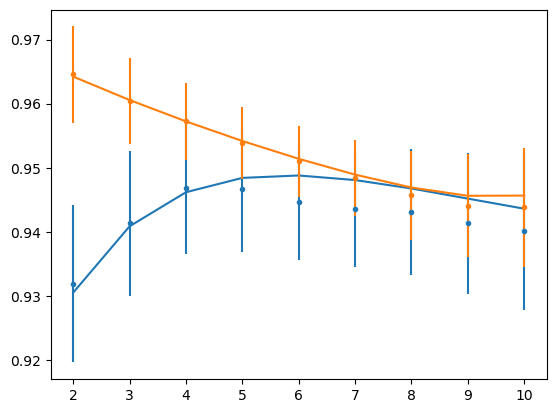

In [218]:
mom = '300'

tmp = np.concatenate([v for x,v in data[mom]['QPLUS'].items()])
yvec = gv.mean(tmp)
cov  = gv.evalcov(tmp)


def global_model(x,p):
    aux = []
    for smr in SMSLIST:
        time = x[mom]['QPLUS'][smr]
        aux.append(model_qplus(time,p,mom,smr))
    return np.concatenate(aux)

ps = {
    'dE_D': '0.5(5)',
    'dM_B': '0.5(5)',
    'dM_D': '0.5(5)',
}
# ps[f'qplus_dm'] = '0.5(5)'
ps[f'qplus_{mom}_f0'] = '1(.5)'
ps[f'qplus_{mom}_RW'] = ['0(1)','0(1)','0(1)']
ps[f'qplus_{mom}_1S'] = ['0(1)','0(1)','0(1)']
params = gv.gvar(ps)

fit = lsqfit.nonlinear_fit(
    data  = (xdata,yvec,cov),
    fcn   = global_model,
    prior = params,
)
print(fit)


for i,smr in enumerate(SMSLIST):
    xplot = xdata[mom]['QPLUS'][smr]
    yplot = rdata[mom]['QPLUS'][smr]
    plt.errorbar(xplot,gv.mean(yplot),gv.sdev(yplot),fmt='.',color=f'C{i}')

    plt.plot(xplot,model_qplus(xplot,fit.pmean,mom,smr),color=f'C{i}')


# today

In [219]:
MOMLIST = ['100','200','300','400']
RATLIST = ['XF','RMINUS','QPLUS']
SMSLIST = ['1S','RW']

In [243]:
data = {}
for mom in MOMLIST:
    data[mom] = {rat: rdata[mom][rat] for rat in RATLIST}

data['000'] = {'RPLUS': rdata['000']['RPLUS']}

In [257]:
params = {
    'dE_D': '0.5(5)',
    'dM_B': '0.5(5)',
    'dM_D': '0.5(5)',
}
# params[f'qplus_dm'] = '0.5(5)'

for mom in MOMLIST:
    params[f'xf_{mom}_f0'    ] = '0(1)'
    params[f'xf_{mom}_1S'    ] = ['0(1)','0(1)']
    params[f'xf_{mom}_RW'    ] = ['0(1)','0(1)']

    params[f'rminus_{mom}_f0'] = '0(1)'
    params[f'rminus_{mom}_1S'] = ['0(1)','0(1)']
    params[f'rminus_{mom}_RW'] = ['0(1)','0(1)']

    params[f'qplus_{mom}_f0'] = '1(1)'
    params[f'qplus_{mom}_1S'] = ['0(1)','0(1)','0(1)']
    params[f'qplus_{mom}_RW'] = ['0(1)','0(1)','0(1)']

params[f'rplus_000_f0'] = '0(1)'
params[f'rplus_000_1S'] = ['0(1)','0(1)','0(1)','0(1)']
params[f'rplus_000_RW'] = ['0(1)','0(1)','0(1)','0(1)']

params = gv.gvar(params)

In [259]:
def model_xf(t,p,mom,smr):
    return p[f'xf_{mom}_f0'] + \
        p[f'xf_{mom}_{smr}'][0] * np.exp(-(   t))**p['dE_D'] + \
        p[f'xf_{mom}_{smr}'][1] * np.exp(-(Ta-t))**p['dM_B'] 
    

def model_rminus(t,p,mom,smr):
    return p[f'rminus_{mom}_f0'] + \
        p[f'rminus_{mom}_{smr}'][0] * np.exp(-(   t))**p['dE_D'] + \
        p[f'rminus_{mom}_{smr}'][1] * np.exp(-(Ta-t))**p['dM_B'] 

def model_qplus(t,p,mom,smr):
    return p[f'qplus_{mom}_f0'] + \
        p[f'qplus_{mom}_{smr}'][0] * np.exp(-(   t))**p['dE_D'] + \
        p[f'qplus_{mom}_{smr}'][1] * np.exp(-(Ta-t))**p['dM_B'] + \
        p[f'qplus_{mom}_{smr}'][2] * np.exp(-(   t))**p['dM_D'] 

def model_rplus(t,p,mom,smr):
    return p[f'rplus_{mom}_f0'] + \
        p[f'rplus_{mom}_{smr}'][0] * np.exp(-(   t))**p['dE_D'] + \
        p[f'rplus_{mom}_{smr}'][1] * np.exp(-(Ta-t))**p['dM_B'] + \
        p[f'rplus_{mom}_{smr}'][2] * np.exp(-(   t))**p['dM_B'] + \
        p[f'rplus_{mom}_{smr}'][3] * np.exp(-(Ta-t))**p['dM_D'] * np.exp((   t))**p['dM_B']

In [260]:
models = {
    'xf'    : model_xf,
    'rminus': model_rminus,
    'qplus' : model_qplus,
    'rplus' : model_rplus,
}
keys = list(itertools.product(MOMLIST,RATLIST,SMSLIST))
keys.append(('000','RPLUS','1S'))
keys.append(('000','RPLUS','RW'))

def global_model(x,p): # x shall be a tree
    aux = []
    for mom,rat,smr in keys:
        time = x[mom][rat][smr]
        aux.append(
            models[rat.lower()](time,p,mom,smr)
        )
    return np.concatenate(aux)


In [261]:
tmp = []
for mom,rat,smr in keys:
    tmp.append(data[mom][rat][smr])
tmp = np.concatenate(tmp)

yvec = gv.mean(tmp)
cov  = gv.evalcov(tmp)

In [262]:
fit = lsqfit.nonlinear_fit(
    data  = (xdata,yvec,cov),
    fcn   = global_model,
    prior = params,
    verbose = True
)

`ftol` termination condition is satisfied.
Function evaluations 57, initial cost 1.6817e+07, final cost 7.8656e+01, first-order optimality 4.11e+00.


In [263]:
print(fit)

Least Square Fit:
  chi2/dof [dof] = 0.67 [234]    Q = 1    logGBF = 891.74

Parameters:
           dE_D      0.429 (19)      [  0.50 (50) ]  
           dM_B       0.93 (21)      [  0.50 (50) ]  
           dM_D      0.195 (87)      [  0.50 (50) ]  
      xf_100_f0   -0.06212 (94)      [    0 ± 1.0 ]  
    xf_100_1S 0     0.0276 (35)      [    0 ± 1.0 ]  
              1     0.0222 (90)      [    0 ± 1.0 ]  
    xf_100_RW 0    -0.0093 (33)      [    0 ± 1.0 ]  
              1     0.0234 (96)      [    0 ± 1.0 ]  
  rminus_100_f0    -0.0690 (11)      [    0 ± 1.0 ]  
rminus_100_1S 0     0.0290 (71)      [    0 ± 1.0 ]  
              1     0.0137 (72)      [    0 ± 1.0 ]  
rminus_100_RW 0     0.0004 (66)      [    0 ± 1.0 ]  
              1     0.0146 (78)      [    0 ± 1.0 ]  
   qplus_100_f0     0.9991 (59)      [  1.0 (1.0) ]  
 qplus_100_1S 0     -0.013 (12)      [    0 ± 1.0 ]  
              1     0.0067 (42)      [    0 ± 1.0 ]  
              2   -0.0003 (198)      [    0 ± 1

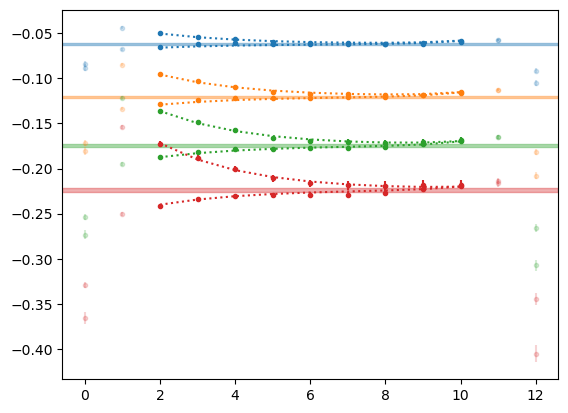

In [267]:
ratio = 'XF'
for i,mom in enumerate(MOMLIST):
    robj = objs[mom][ratio]
    xd,yd = robj.format()

    for smr in SMSLIST:
        xplot = xdata[mom][ratio][smr]
        
        mask = np.array([x in xplot for x in xd] )
        plt.errorbar(
            xd[mask],
            gv.mean(yd[smr][mask]),
            gv.sdev(yd[smr][mask]),
            fmt='.',
            color=f'C{i}'
        )

        plt.errorbar(
            xd[~mask],
            gv.mean(yd[smr][~mask]),
            gv.sdev(yd[smr][~mask]),
            fmt='.',
            color=f'C{i}',
            alpha = 0.2
        )
        
        plt.plot(
            xplot,
            models[ratio.lower()](xplot,fit.pmean,mom,smr),
            linestyle=':',
            color=f'C{i}'
        )

        f0 = fit.p[f'{ratio.lower()}_{mom}_f0']
        plt.axhspan(
            f0.mean-f0.sdev,f0.mean+f0.sdev,
            color = f'C{i}',
            alpha=0.2
        )

In [269]:
tmp = []
for mom in MOMLIST:
    for rat in RATLIST:
        df = {
            'mom': mom,
            'ratio': rat,
            'f0': fit.p[f'{rat.lower()}_{mom}_f0']
        }
        tmp.append(df)

tmp.append({
    'mom': '000',
    'ratio': 'RPLUS',
    'f0': fit.p[f'rplus_000_f0']
})

pd.DataFrame(tmp).set_index(['mom','ratio'])

f0
mom ratio               
100 XF      -0.06212(94)
    RMINUS   -0.0690(11)
    QPLUS     0.9991(59)
200 XF       -0.1205(12)
    RMINUS   -0.1332(14)
    QPLUS     0.9818(65)
300 XF       -0.1747(15)
    RMINUS   -0.1930(20)
    QPLUS      0.938(12)
400 XF       -0.2238(22)
    RMINUS   -0.2458(31)
    QPLUS      0.880(25)
000 RPLUS     1.0111(44)